In [67]:
# Manage imports
from pathlib import Path
import GpxAudioLabeler as gwl

In [68]:
# Assign data home directory, collection filename, sampling filepath, and clip home directory
data_home = str(Path("~").expanduser() / "Data" / "AISonobuoy")
collection_filename = "collection.json"
sampling_filepath = str(Path("GpxAudioLabeler").parent / "data" / "sampling.json")
clip_home = Path("~").expanduser() / "Datasets" / "AISonobuoy"

In [69]:
# Load file describing the collection
collection_path = Path(data_home) / collection_filename
collection = gwl.load_json_file(collection_path)

2022-04-11 08:35:58,139 - GpxAudioLabeler - INFO - Loading /Users/raymondleclair/Data/AISonobuoy/collection.json


In [70]:
# Identify the interval during which any source emitted
src_min_start_t = min([h["start_t"] for h in collection["sources"]]) * 1000  # [ms]
src_max_stop_t = max([h["stop_t"] for h in collection["sources"]]) * 1000  # [ms]

# Identify the interval during which all hydrophone collected
hyd_max_start_t = (
    max([h["start_t"] for h in collection["hydrophones"]]) * 1000
)  # [ms]
hyd_min_stop_t = (
    min([h["stop_t"] for h in collection["hydrophones"]]) * 1000
)  # [ms]

In [71]:
# Load file describing the sampling cases
# NOTE: Edit this file to change parameters
sampling = gwl.load_json_file(sampling_filepath)

2022-04-11 08:35:59,862 - GpxAudioLabeler - INFO - Loading data/sampling.json


In [72]:
# Consider the first source
source = collection["sources"][0]
gpx_path = Path(data_home) / source["name"]
gpx = gwl.parse_source_gpx_file(gpx_path)

2022-04-11 08:36:00,413 - GpxAudioLabeler - INFO - Parsing /Users/raymondleclair/Data/AISonobuoy/suuntoapp-Motorsports-2022-02-22T18-09-01Z-track.gpx


In [73]:
# Consider each hydrophone
hydrophone = collection["hydrophones"][0]
wav_path = Path(data_home) / hydrophone["name"]
audio = gwl.get_hydrophone_wav_file(wav_path)

2022-04-11 08:36:01,002 - GpxAudioLabeler - INFO - Getting /Users/raymondleclair/Data/AISonobuoy/Unit-01.WAV


In [74]:
# Export audio with no source present, if it exists
if src_max_stop_t < hyd_min_stop_t:
    gwl.export_audio_interval(
        audio,
        src_max_stop_t,
        hyd_min_stop_t,
        Path(clip_home) / f"{Path(hydrophone['name'].lower()).stem}-no-source.wav",
    )

2022-04-11 08:36:03,117 - GpxAudioLabeler - INFO - Computing source suuntoapp-Motorsports-2022-02-22T18-09-01Z-track.gpx metrics for hydrophone unit-01
2022-04-11 08:36:03,120 - GpxAudioLabeler - INFO - Found 4311 valid values out of all 4619 values
2022-04-11 08:36:03,129 - GpxAudioLabeler - INFO - Plotting source suuntoapp-Motorsports-2022-02-22T18-09-01Z-track.gpx metrics for hydrophone unit-01


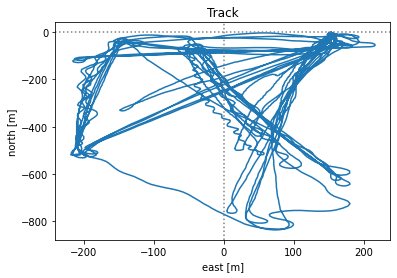

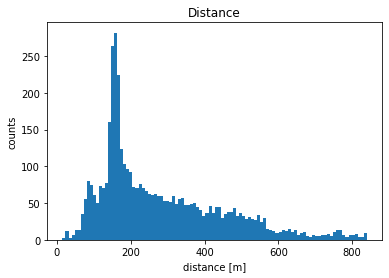

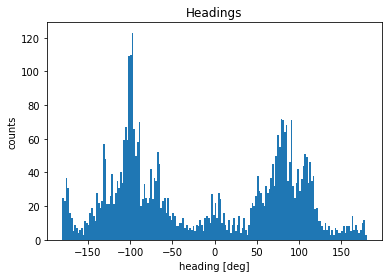

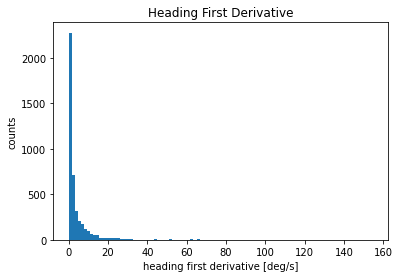

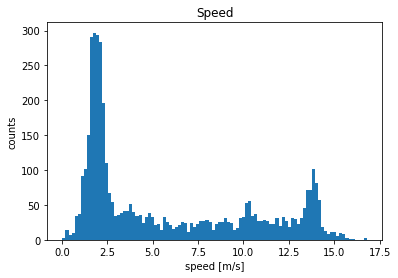

In [75]:
# Compute and plot source metrics for the current hydrophone
(
    vld_t,
    distance,
    heading,
    heading_dot,
    speed,
    r_s_h,
    v_s_h,
) = gwl.compute_source_metrics(source, gpx, hydrophone)
gwl.plot_source_metrics(
    source, hydrophone, heading, heading_dot, distance, speed, r_s_h
)

In [76]:
# Consider the first sampling case
case = sampling[0]
clip_home = Path(clip_home) / case["output_dir"]
if not clip_home.exists():
    clip_home.mkdir(parents=True)
method = case["method"]

In [77]:
if method["type"] == "clusters":
    (
        distance_clusters,
        heading_clusters,
        heading_dot_clusters,
        speed_clusters,
    ) = gwl.cluster_source_metrics(
        distance,
        method["distance_n_clusters"],
        heading,
        method["heading_n_clusters"],
        heading_dot,
        method["heading_dot_n_clusters"],
        speed,
        method["speed_n_clusters"],
    )
    gwl.slice_source_audio_by_cluster(
        hydrophone,
        audio,
        hyd_max_start_t,
        hyd_min_stop_t,
        vld_t,
        r_s_h,
        distance_clusters,
        heading_clusters,
        heading_dot_clusters,
        speed_clusters,
        case["delta_t_max"],
        case["n_clips_max"],
        clip_home,
        do_plot=False,
    )
elif method["type"] == "conditionals":
    gwl.slice_source_audio_by_condition(
        hydrophone,
        audio,
        hyd_max_start_t,
        hyd_min_stop_t,
        vld_t,
        r_s_h,
        distance,
        method["distance_limits"],
        heading,
        method["heading_limits"],
        heading_dot,
        method["heading_dot_limits"],
        speed,
        method["speed_limits"],
        case["delta_t_max"],
        case["n_clips_max"],
        clip_home,
        do_plot=False,
    )

2022-04-11 08:36:04,301 - GpxAudioLabeler - INFO - Computing clusters of heading, distance, and speed
2022-04-11 08:36:06,986 - GpxAudioLabeler - INFO - Slicing source audio by heading, heading first derivative, distance, and speed clusters
